# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [4]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [5]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [6]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

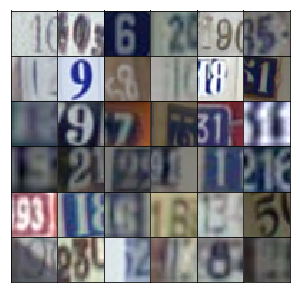

In [7]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [8]:
def scale(x, feature_range=(-1, 1)):
    # scale all the pixel's value range from -1 to 1.
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

这个output_dim是不是最后一个的层数?
不像, 后面有了

这个output dimenssion就是32\*32\*3

### 题目要求
1. 因为需要最后的图片大小是32 32 3
    - 所以需要第一个图片的大小是4 \* 4 \* 512
    - 这样到最后一层的时候就是需要的大小了.
2. 把全连接网络变成第一层的输入.
    - 噪声变成第一层输入的shape之后再使用bn
3. reshape的shape参数解释, 哇什么第一个数值是-1.
    - 第一个是-1 是为了给batch size的参数, 这里传入一个placeholder.
4. conv2d_transpose 里面的filter的参数的意思.
    - 是feature map的层数.
    - kernel size 是5, 为什么?
        - 图上面标注了size是5, 仔细看.
5. 网络结构的问题
    - 因为每一次卷积, 图片大小缩小0.5倍, 所以stride是2.
6. 为什么卷积网络还是使用bias.
    - 
7. 为什么使用的是same padding?
    - 只有使用same padding,配合stride == 2, 才可以让图片缩小一倍.

In [21]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    def leaky_relu(input):
        return tf.maximum(tf.multiply(input, alpha), input)
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1= tf.layers.dense(z, 4*4*512, use_bias=False)
        x1= tf.reshape(x1, (-1, 4, 4, 512))
        x1= tf.layers.batch_normalization(x1, training=training)
        x1= leaky_relu(x1)
        # 4 4 512
        # Output layer, 32x32x3
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, use_bias=False, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = leaky_relu(x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, use_bias=False, padding='same')
        x3 = tf.layers.batch_normalization(x3)
        x3 = leaky_relu(x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, 2, use_bias=False, padding='same')
        x4 = tf.layers.batch_normalization(x4)
        x4 = leaky_relu(x4)
        
        logits = tf.layers.conv2d_transpose(x4, output_dim, 5, 2, use_bias=False, padding='same')
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

### 这里的reshape的形状
1. 这里的形状应该是 batch_size x features
    - batch_size 不确定所以使用 -1
    - features 使用 4 x 4 x 256

In [ ]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 64, 5, 2, 'same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # 16x16x64
        x = tf.layers.conv2d(x, 128, 5, 2, 'same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x*alpha)
        # 8x8x128
        x = tf.layers.conv2d(x, 256, 5, 2, 'same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x*alpha)
        # 4x4x256
        x = tf.reshape(x, [-1, 4*4*256])
        logits = tf.layers.dense(x, 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [15]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [17]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph() # If the GPU is not valiable, uncomment this line.
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [18]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [19]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                # 论文里面写了使用正态分布更好.

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [24]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 64
epochs = 1
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.3439
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 1.6594


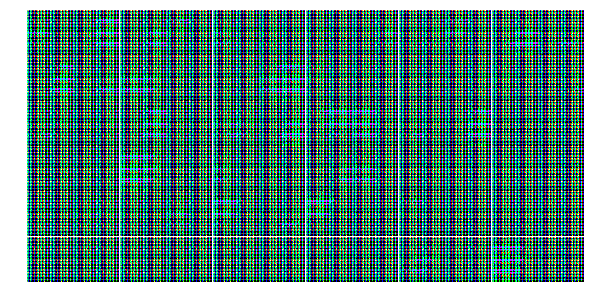

Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 1.8616
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 2.2627
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 2.4179
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 2.8080
Epoch 1/1... Discriminator Loss: 0.1592... Generator Loss: 2.6770
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 2.3777


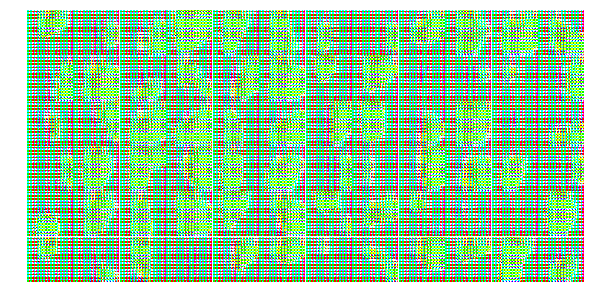

Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.7087
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 2.9172
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 2.7575
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 3.1153
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 3.3856
Epoch 1/1... Discriminator Loss: 0.0959... Generator Loss: 3.4395
Epoch 1/1... Discriminator Loss: 0.0934... Generator Loss: 3.1477
Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.1694... Generator Loss: 3.5482
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 2.7508


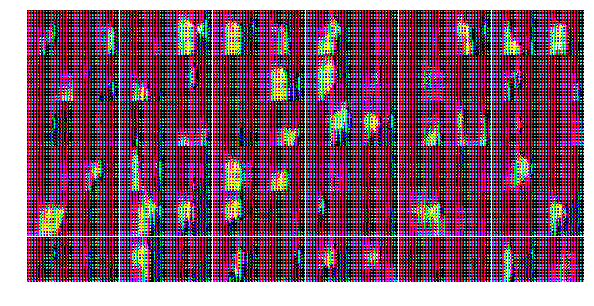

Epoch 1/1... Discriminator Loss: 0.1551... Generator Loss: 3.4390
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 3.6556
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.4717
Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 2.6530
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 3.2660
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 4.2650
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 4.1613
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 3.9721
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.8370
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 3.9343


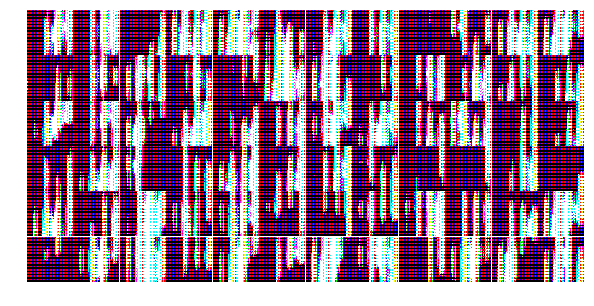

Epoch 1/1... Discriminator Loss: 0.0388... Generator Loss: 4.4610
Epoch 1/1... Discriminator Loss: 0.0335... Generator Loss: 4.5061
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 4.3001
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 4.0684
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 4.2669
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 3.9358
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 4.9704
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 3.9893
Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 4.7251
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 4.0038


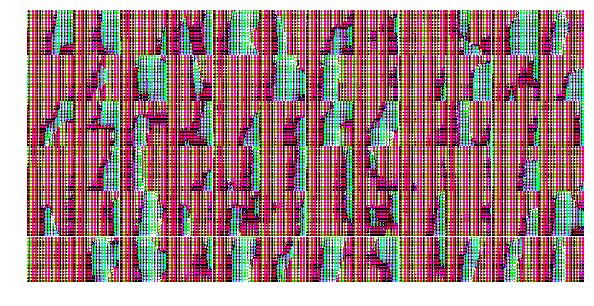

Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 4.8306
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 5.2746
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 5.1969
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.1219
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.1256
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 5.0385
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 4.8885
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 5.2791
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.0940
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 5.0235


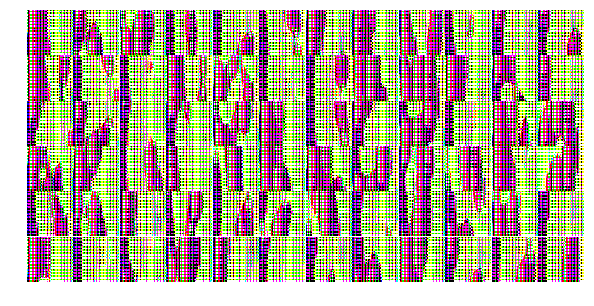

Epoch 1/1... Discriminator Loss: 0.0212... Generator Loss: 4.6773
Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 3.7398
Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 4.9924
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 5.1020
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 5.1342
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 4.6734
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.6557
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 3.6446
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 5.0178
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 3.6311


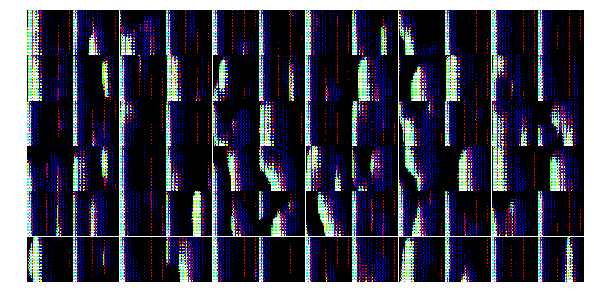

Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 3.6772
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 4.1918
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 4.1794
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 3.5850
Epoch 1/1... Discriminator Loss: 0.0924... Generator Loss: 3.8177
Epoch 1/1... Discriminator Loss: 0.2452... Generator Loss: 3.5465
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 3.9098
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 3.9520
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 4.7476
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 4.5274


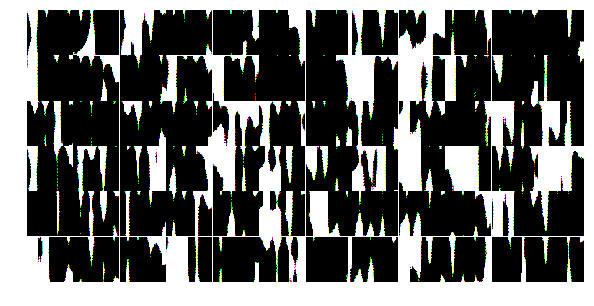

Epoch 1/1... Discriminator Loss: 0.0346... Generator Loss: 4.6012
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 4.4021
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 4.6847
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 4.8900
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 4.9158
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 4.9207
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 5.1037
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 4.9283
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 5.2520
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 5.3140


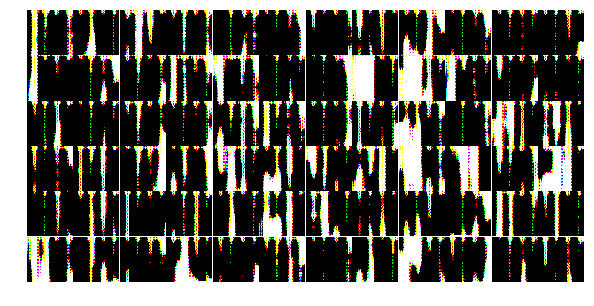

Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 5.5481
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.4652
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 5.4220
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.1989
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 5.6634
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 5.8123
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 5.2633
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.4437
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 5.1445
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.4657


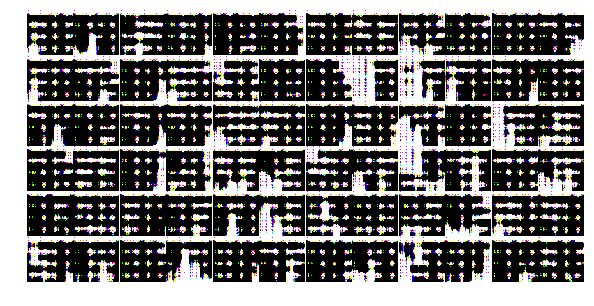

Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.5306
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 5.5358
Epoch 1/1... Discriminator Loss: 0.0138... Generator Loss: 5.6650
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 5.4884
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 5.8058
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.8831
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 5.4922
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 5.2566
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 5.4916
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.0654


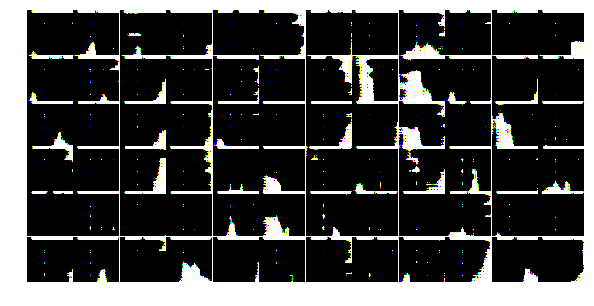

Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 5.5640
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 5.5499
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 5.3492
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.8046


In [25]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

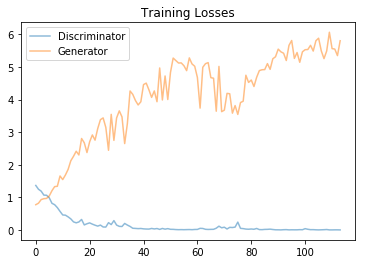

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

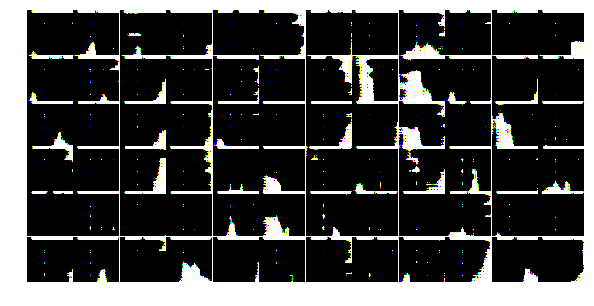

In [27]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))